<a href="https://colab.research.google.com/github/bcdanl/320-code/blob/main/danl_320_script_2025_0303.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, when, log
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [11]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()

    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(MODEL, ASSEMBLER))

def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

In [17]:
oj = pd.read_csv('https://bcdanl.github.io/data/dominick_oj_feat.csv')

In [18]:
oj

,sales,price,brand,ad_status
0,8256.0,3.87,tropicana,No Ad
1,6144.0,3.87,tropicana,No Ad
2,3840.0,3.87,tropicana,No Ad
3,8000.0,3.87,tropicana,No Ad
4,8896.0,3.87,tropicana,No Ad
...,...,...,...,...
28942,2944.0,2.00,dominicks,No Ad
28943,4928.0,1.94,dominicks,No Ad
28944,13440.0,1.59,dominicks,No Ad
28945,55680.0,1.49,dominicks,No Ad


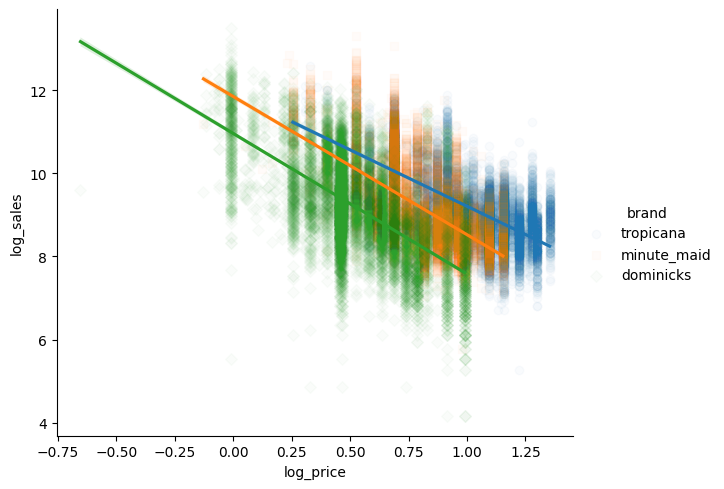

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

oj['log_price'] = oj['price'].apply(lambda x: np.log(x))
oj['log_sales'] = oj['sales'].apply(lambda x: np.log(x))

sns.lmplot(
    x='log_price',
    y='log_sales',
    hue='brand',     # color by brand
    data=oj,
    aspect=1.2,
    height=5,
    markers=["o", "s", "D"],  # optional: different markers per brand
    scatter_kws={'alpha': 0.025},  # Pass alpha to the scatter plot
    legend=True
)

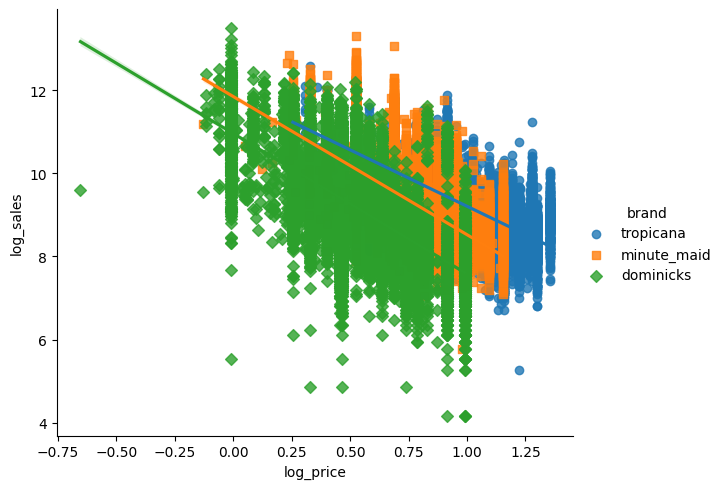

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

oj['log_price'] = oj['price'].apply(lambda x: np.log(x))
oj['log_sales'] = oj['sales'].apply(lambda x: np.log(x))

sns.lmplot(
    x='log_price',
    y='log_sales',
    hue='brand',     # color by brand
    data=oj,
    aspect=1.2,
    height=5,
    markers=["o", "s", "D"],  # optional: different markers per brand
    #scatter_kws={'alpha': 0.025},  # Pass alpha to the scatter plot
    legend=True
)

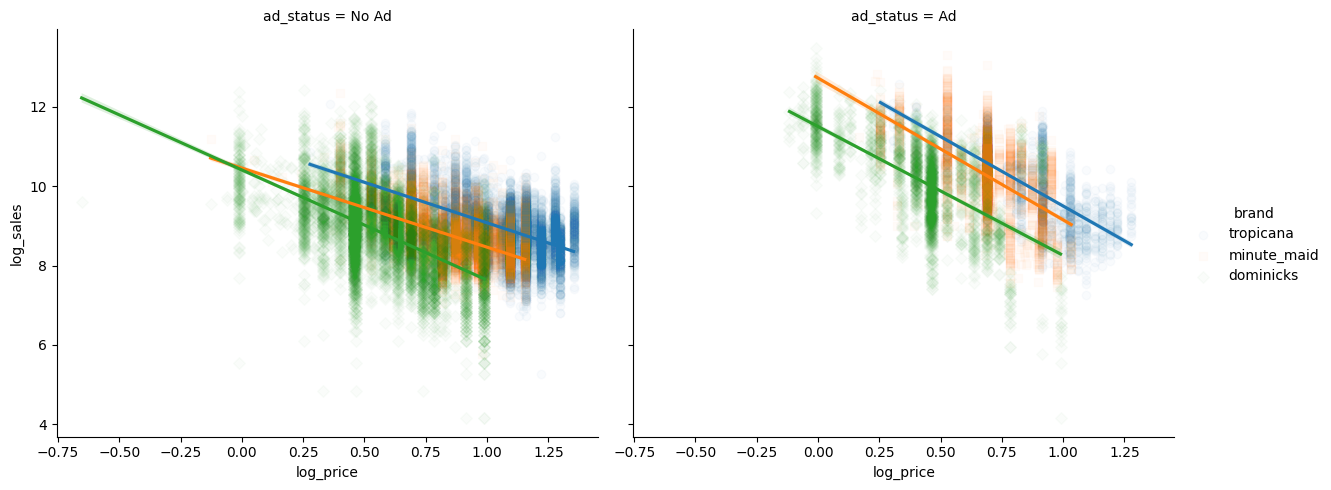

In [22]:
sns.lmplot(
    x='log_price',
    y='log_sales',
    hue='brand',     # color by brand
    col='ad_status',         # facet by feat
    data=oj,
    aspect=1.2,
    height=5,
    markers=["o", "s", "D"],  # optional: different markers per brand
    # Pass alpha to the scatter plot
    scatter_kws={'alpha': 0.025},
    col_wrap=2,         # how many facets per row
    legend=True
)

In [23]:
# 1. Read CSV data from URL
df = spark.createDataFrame(oj)
df.show()

+-------+-----+---------+---------+------------------+-----------------+
|  sales|price|    brand|ad_status|         log_price|        log_sales|
+-------+-----+---------+---------+------------------+-----------------+
| 8256.0| 3.87|tropicana|    No Ad|1.3532545070416904|9.018695487721343|
| 6144.0| 3.87|tropicana|    No Ad|1.3532545070416904|8.723231274827508|
| 3840.0| 3.87|tropicana|    No Ad|1.3532545070416904|8.253227645581772|
| 8000.0| 3.87|tropicana|    No Ad|1.3532545070416904|8.987196820661973|
| 8896.0| 3.87|tropicana|    No Ad|1.3532545070416904|9.093357016490364|
| 7168.0| 3.87|tropicana|    No Ad|1.3532545070416904|8.877381954654766|
|10880.0| 3.29|tropicana|    No Ad|1.1908875647772805|9.294681520409934|
| 7744.0| 3.29|tropicana|    No Ad|1.1908875647772805|8.954673628956414|
| 8512.0| 3.29|tropicana|    No Ad|1.1908875647772805|9.049232211581426|
| 5504.0| 3.29|tropicana|    No Ad|1.1908875647772805| 8.61323037961318|
| 5888.0| 3.56|tropicana|    No Ad| 1.2697605448639

In [43]:
dtrain, dtest = df.randomSplit([0.9, 0.1], seed = 1234)


In [44]:
dummy_cols_brand, ref_category_brand = add_dummy_variables('brand', 0)


Reference category (dummy omitted): dominicks


In [45]:
dummy_cols_ad, ref_category_ad = add_dummy_variables('ad_status', 1)


Reference category (dummy omitted): No Ad


In [27]:
dtrain.show()

+-----+-----+-----------+---------+------------------+------------------+---------------+-----------------+---------------+------------+---------------+
|sales|price|      brand|ad_status|         log_price|         log_sales|brand_dominicks|brand_minute_maid|brand_tropicana|ad_status_Ad|ad_status_No_Ad|
+-----+-----+-----------+---------+------------------+------------------+---------------+-----------------+---------------+------------+---------------+
| 64.0| 2.69|  dominicks|    No Ad|0.9895411936137477|4.1588830833596715|              1|                0|              0|           0|              1|
|128.0| 1.39|  dominicks|    No Ad|0.3293037471426003| 4.852030263919617|              1|                0|              0|           0|              1|
|192.0| 2.69|  dominicks|    No Ad|0.9895411936137477|5.2574953720277815|              1|                0|              0|           0|              1|
|192.0| 2.69|  dominicks|    No Ad|0.9895411936137477|5.2574953720277815|         

# Model 1

In [46]:
conti_cols = ["log_price"]
assembler_predictors = (
    conti_cols +
    dummy_cols_brand
)

assembler_1 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_1 = assembler_1.transform(dtrain)
dtest_1  = assembler_1.transform(dtest)

model_1 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_sales")
    .fit(dtrain_1)
)
dtest_1 = model_1.transform(dtest_1) # Q4. adding prediction column to test data

# For model_dum and assembler:
print( regression_table(model_1, assembler_1) )

+-------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                  |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: log_price         | -3.152 | ***  |      0.014 |   0.000 |       -3.179 |       -3.125 |
| Beta: brand_minute_maid |  0.876 | ***  |      0.017 |   0.000 |        0.842 |        0.909 |
| Beta: brand_tropicana   |  1.537 | ***  |      0.015 |   0.000 |        1.507 |        1.567 |
| Intercept               | 10.836 | ***  |      0.024 |   0.000 |       10.788 |       10.883 |
------------------------------------------------------------------------------------------------
| Observations            | 26,040 |      |            |         |              |              |
| R²                      |  0.394 |      |            |         |              |              |
| RMSE                    |  0

In [29]:
np.exp(model_1.coefficients)

array([0.04153995, 2.41567703, 4.70887611])

In [32]:
np.exp(1.549)

4.706761067358193

# Model 2

In [33]:
def add_interaction_terms(var_list1, var_list2, var_list3=None):
    """
    Creates interaction term columns in the global DataFrames dtrain and dtest.

    For two sets of variable names (which may represent categorical (dummy) or continuous variables),
    this function creates two-way interactions by multiplying each variable in var_list1 with each
    variable in var_list2.

    Optionally, if a third list of variable names (var_list3) is provided, the function also creates
    three-way interactions among each variable in var_list1, each variable in var_list2, and each variable
    in var_list3.

    Parameters:
        var_list1 (list): List of column names for the first set of variables.
        var_list2 (list): List of column names for the second set of variables.
        var_list3 (list, optional): List of column names for the third set of variables for three-way interactions.

    Returns:
        A flat list of new interaction column names.
    """
    global dtrain, dtest

    interaction_cols = []

    # Create two-way interactions between var_list1 and var_list2.
    for var1 in var_list1:
        for var2 in var_list2:
            col_name = f"{var1}_*_{var2}"
            dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double"))
            interaction_cols.append(col_name)

    # Create two-way interactions between var_list1 and var_list3.
    if var_list3 is not None:
      for var1 in var_list1:
          for var3 in var_list3:
              col_name = f"{var1}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # Create two-way interactions between var_list2 and var_list3.
    if var_list3 is not None:
      for var2 in var_list2:
          for var3 in var_list3:
              col_name = f"{var2}_*_{var3}"
              dtrain = dtrain.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              dtest = dtest.withColumn(col_name, col(var2).cast("double") * col(var3).cast("double"))
              interaction_cols.append(col_name)

    # If a third list is provided, create three-way interactions.
    if var_list3 is not None:
        for var1 in var_list1:
            for var2 in var_list2:
                for var3 in var_list3:
                    col_name = f"{var1}_*_{var2}_*_{var3}"
                    dtrain = dtrain.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    dtest = dtest.withColumn(col_name, col(var1).cast("double") * col(var2).cast("double") * col(var3).cast("double"))
                    interaction_cols.append(col_name)

    return interaction_cols

 # Example
 # interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
 # interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

In [47]:
interaction_cols_brand_price = add_interaction_terms(dummy_cols_brand, ['log_price'])
interaction_cols_brand_ad_price = add_interaction_terms(dummy_cols_brand, dummy_cols_ad, ['log_price'])

In [54]:
interaction_cols_brand_ad_price

['brand_minute_maid_*_ad_status_Ad',
 'brand_tropicana_*_ad_status_Ad',
 'brand_minute_maid_*_log_price',
 'brand_tropicana_*_log_price',
 'ad_status_Ad_*_log_price',
 'brand_minute_maid_*_ad_status_Ad_*_log_price',
 'brand_tropicana_*_ad_status_Ad_*_log_price']

In [36]:
dtrain.show()

+-----+-----+-----------+---------+------------------+------------------+---------------+-----------------+---------------+------------+---------------+-----------------------------+---------------------------+--------------------------------+------------------------------+------------------------+--------------------------------------------+------------------------------------------+
|sales|price|      brand|ad_status|         log_price|         log_sales|brand_dominicks|brand_minute_maid|brand_tropicana|ad_status_Ad|ad_status_No_Ad|brand_minute_maid_*_log_price|brand_tropicana_*_log_price|brand_minute_maid_*_ad_status_Ad|brand_tropicana_*_ad_status_Ad|ad_status_Ad_*_log_price|brand_minute_maid_*_ad_status_Ad_*_log_price|brand_tropicana_*_ad_status_Ad_*_log_price|
+-----+-----+-----------+---------+------------------+------------------+---------------+-----------------+---------------+------------+---------------+-----------------------------+---------------------------+--------------

In [48]:
conti_cols = ["log_price"]
assembler_predictors = (
    conti_cols +
    dummy_cols_brand +
    interaction_cols_brand_price
)

assembler_2 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_2 = assembler_2.transform(dtrain)
dtest_2  = assembler_2.transform(dtest)

model_2 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_sales")
    .fit(dtrain_2)
)
dtest_2 = model_2.transform(dtest_2)

# For model_dum and assembler:
print( regression_table(model_2, assembler_2) )

+-------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                              |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+-------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: log_price                     | -3.410 | ***  |      0.044 |   0.000 |       -3.496 |       -3.324 |
| Beta: brand_minute_maid             |  0.868 | ***  |      0.049 |   0.000 |        0.771 |        0.964 |
| Beta: brand_tropicana               |  0.955 | ***  |      0.061 |   0.000 |        0.836 |        1.073 |
| Beta: brand_minute_maid_*_log_price |  0.095 |      |      0.057 |   0.115 |       -0.016 |        0.207 |
| Beta: brand_tropicana_*_log_price   |  0.688 | ***  |      0.022 |   0.000 |        0.645 |        0.731 |
| Intercept                           | 10.972 | ***  |      0.039 |   0.000 |       10.896 |       11.047 |
-------------------

In [38]:
# tropicana
-3.400 + 0.626

-2.774

In [ ]:
# dominicks
-3.400

In [ ]:
# mm
-3.400

# Model 3

Text(0, 0.5, 'Proportion')

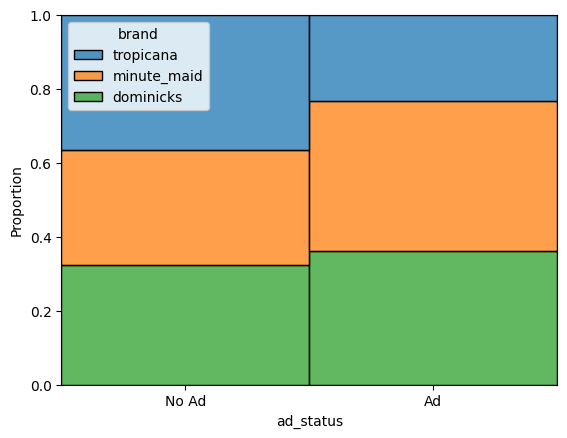

In [39]:
sns.histplot(
    data=oj,
    x='ad_status',   # categorical variable on the x-axis
    hue='brand',     # fill color by brand
    multiple='fill'  # 100% stacked bars
)
plt.ylabel('Proportion')

In [49]:
interaction_cols_brand_price

['brand_minute_maid_*_log_price', 'brand_tropicana_*_log_price']

In [50]:
interaction_cols_brand_ad_price

['brand_minute_maid_*_ad_status_Ad',
 'brand_tropicana_*_ad_status_Ad',
 'brand_minute_maid_*_log_price',
 'brand_tropicana_*_log_price',
 'ad_status_Ad_*_log_price',
 'brand_minute_maid_*_ad_status_Ad_*_log_price',
 'brand_tropicana_*_ad_status_Ad_*_log_price']

In [63]:
conti_cols = ["log_price"]
assembler_predictors = (
    conti_cols +
    dummy_cols_brand + dummy_cols_ad +
    interaction_cols_brand_ad_price

)

assembler_3 = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_3 = assembler_3.transform(dtrain)
dtest_3  = assembler_3.transform(dtest)

model_3 = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_sales")
    .fit(dtrain_3)
)
dtest_3 = model_3.transform(dtest_3)

# For model_dum and assembler:
print( regression_table(model_3, assembler_3) )

+----------------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                                             |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+----------------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: log_price                                    | -2.797 | ***  |      0.049 |   0.000 |       -2.894 |       -2.701 |
| Beta: brand_minute_maid                            |  0.029 |      |      0.054 |   0.561 |       -0.077 |        0.134 |
| Beta: brand_tropicana                              |  0.681 | ***  |      0.041 |   0.000 |        0.601 |        0.760 |
| Beta: ad_status_Ad                                 |  1.095 | ***  |      0.087 |   0.000 |        0.925 |        1.265 |
| Beta: brand_minute_maid_*_ad_status_Ad             |  1.183 | ***  |      0.105 |   0.000 |        0.978 |        1.389 |
| Beta: 

In [60]:
model_3.coefficients

DenseVector([-3.4442, -0.3859, 0.2663, 2.2785, 1.9088, 1.4601, 1.413, 1.4113, -3.0065, -2.8854])

In [62]:
model_3.summary.coefficientStandardErrors

[0.03434305452776086,
 0.04741732367284524,
 0.05246396575153095,
 0.07764710732668735,
 0.0981769445738194,
 0.0612717056552329,
 0.056288159846165545,
 0.03509027174543209,
 0.11001333743598153,
 0.11305873219458323,
 0.01992008199348956]